In [1]:
from vessel_classifier import VesselClassifier
import os
import PIL
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [2]:
# Load data
img_path = '../OSIRIX Images'
seg_path = '../Ground Truth'

def parse_seg(seg):
    seg = np.asarray(seg)
    seg[seg[...,3] == 0] = 0
    seg = seg[...,:3]
    seg[seg>0] = 1
    seg = np.squeeze(seg[...,0])
    return seg.astype(np.uint8)

images, segmentations = [], []

for imname in os.listdir(img_path):
    fname = os.path.join(img_path, imname)
    img = PIL.Image.open(fname).convert("L")
    img = np.asarray(img).astype(np.uint8)
    
    seg1_name = os.path.join(seg_path, "Observer 1", imname.replace(".jpg", ".png"))
    seg1 = PIL.Image.open(seg1_name) #.convert("L")
    seg2_name = os.path.join(seg_path, "Observer 2", imname.replace(".jpg", ".png"))
    seg2 = PIL.Image.open(seg2_name) #.convert("L")
    
    seg1, seg2 = parse_seg(seg1), parse_seg(seg2)
    seg = np.logical_or(seg1, seg2).astype(np.uint8)

    images.append(img)
    segmentations.append(seg)

In [3]:
from filter_extraction import *
from connectivity_features import *

In [4]:
feature_extractors = [
    lambda identity: np.expand_dims(identity, -1),
    hessian_features,
    surrounding_information,
    anisotropic_diffusion,
    morphology,
    kuwahara_features,
    light_sobel_filter,
    entropy_filters,
    gaussian_blurs
]

connectivity_extractors = [
    immediate_connectivity,
    radial_connectivity
]

In [5]:
vessel_classifier = VesselClassifier(
    feature_extractors,
    connectivity_extractors,
    fit_mode='static',
    verbose=1,
    base_estimator=sklearn.ensemble.RandomForestClassifier(
        n_estimators=100, n_jobs=12, max_depth=20
    )
)

In [6]:
vessel_classifier.fit(images[:5], segmentations[:5])

Fitting classifier...


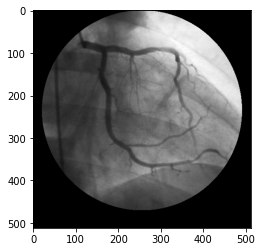

In [7]:
plt.imshow(images[5], plt.cm.gray)
plt.show()

In [8]:
pred = vessel_classifier.predict([images[5]], 0.9)

Starting segmentation for a new image


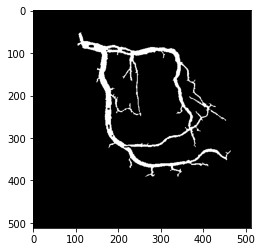

In [9]:
pred0 = pred[0]
pred_closing = cv2.morphologyEx(pred0, cv2.MORPH_CLOSE,
                                np.ones((3,3)), iterations=1)
plt.imshow(pred_closing, plt.cm.gray)
plt.show()